# S3: AirBnb NYC 2024 Listings
by: Tam Trinh           
April 6, 2025         

<a id="0"></a> <br>
## Table of Contents  

- [Set-up and Load Data](#1) 
- [Part 3: Modeling](#2) 
    - [Linear Regression](#3) 
    - [XGBoost](#4)
    - [Random Forest](#5) 

<a id="1"></a>
## Set-up and Load Data

In [1]:
# imports for functionality and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optional imports
import warnings
import pickle

# imports for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [2]:
# ignore warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [3]:
# load cleaned dataset
cleaned_airbnb = pd.read_csv("../data/cleaned_airbnb.csv")

In [4]:
cleaned_limit500 = cleaned_airbnb[cleaned_airbnb["price"] <= 500]

In [5]:
# write cleaned_limit500 to csv
cleaned_limit500.to_csv("../data/cleaned_limit500.csv", index=False)

__________________

<a id="2"></a>
## Part 3: Modeling

### Modeling Prep

#### Train/test split

In [8]:
# split the data into train and test sets
X = cleaned_limit500.loc[:, cleaned_airbnb.columns != "price"]
y = cleaned_limit500["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Create functions for modeling interpretation

In [9]:
def score_r2_rmse_mae(model):
    """A function that prints the R^2 scores for the Train and Test set, RMSE, and MAE scores.
    """

    # print train and test R^2 scores
    print(f"Train score: {model.score(X_train, y_train)}")
    print(f"Test score: {model.score(X_test, y_test)}")

    # make array of y_pred
    y_pred = model.predict(X_test)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)

In [10]:
def truevspred_y(model, X_test, y_test):
    """A function that returns a pointer to a dataframe containing the true y values, the predicted y values, and the difference between them. 
    """

    # get y_pred vals
    y_pred = model.predict(X_test)

    # create df
    truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred, "Diff": (y_test - y_pred)})

    return truevspred_y

<a id="3"></a>
### Linear Regression Modeling

#### Fit initial linear regression model

In [11]:
# initialize linear regression model
linreg = LinearRegression()

# fit logistic regression model to xtrain
linreg.fit(X_train, y_train)

LinearRegression()

In [12]:
# find scores
score_r2_rmse_mae(linreg)

Train score: 0.4164109391444635
Test score: 0.3862578018771333
RMSE: 71.49740301674726
MAE: 51.31882969706625


In [13]:
# compare y_pred to y_true

# predict y_pred values
y_pred = linreg.predict(X_test)

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred, "Diff": (y_test - y_pred)})

# display
y_truevspred

,True_y,Pred_y,Diff
16115,357.0,196.897242,160.102758
1289,85.0,142.190849,-57.190849
2465,190.0,198.587091,-8.587091
9515,286.0,287.332765,-1.332765
12319,180.0,151.433778,28.566222
...,...,...,...
13030,150.0,190.887507,-40.887507
15081,229.0,137.900824,91.099176
9385,100.0,118.910609,-18.910609
3356,214.0,169.474244,44.525756


#### Feature Coefficients

In [9]:
linreg_coef = pd.Series(linreg.coef_, index=X_test.columns)

In [10]:
linreg_coef.sort_values(ascending=False)

roomtype_Entire home/apt           30.330792
roomtype_Hotel room                27.704304
bedrooms                           25.789968
ratings_5                          22.455410
ratings_4.8                        20.073054
neighgroup_Queens                  18.331859
latitude                           16.148882
neighgroup_Manhattan               14.843848
license_Has License                13.724171
license_Exempt                     13.418323
baths                              13.384154
beds                               12.657458
ratings_No rating                   8.003885
neighgroup_Bronx                    6.514783
ratings_4.6                         3.941798
neighgroup_Brooklyn                 3.363830
reviews_per_month                   0.961540
neighborhood_avgprice               0.254980
availability_365                    0.028248
minimum_nights                     -0.009709
calculated_host_listings_count     -0.020297
number_of_reviews                  -0.036622
number_of_

#### Plots of predicted vs actual

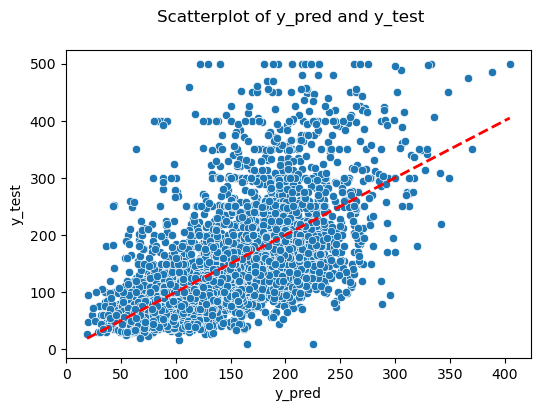

In [15]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


#### Pickle and save model

In [15]:
pickle.dump(linreg, open("../models/linreg_model.pkl","wb"))

In [18]:
# # to load model (optional)
# linreg_model = pickle.load(open("../models/linreg_model.pkl","rb"))

***

<a id="4"></a>
### XGBoost Modeling

In [17]:
# initialize xgboost model
xgb_model = XGBRegressor()

# fit logistic regression model to xtrain
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [20]:
# find scores
score_r2_rmse_mae(xgb_model)

Train score: 0.7979406803824365
Test score: 0.5248005633205888
RMSE: 62.91225232606841
MAE: 43.58188869443704


In [22]:
# compare y_pred to y_true

# predict y_pred values
y_pred = xgb_model.predict(X_test)

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred, "Diff": (y_test - y_pred)})

# display
y_truevspred

,True_y,Pred_y,Diff
16115,357.0,215.126694,141.873306
1289,85.0,126.270203,-41.270203
2465,190.0,227.377457,-37.377457
9515,286.0,333.787903,-47.787903
12319,180.0,209.055313,-29.055313
...,...,...,...
13030,150.0,150.622101,-0.622101
15081,229.0,202.374420,26.625580
9385,100.0,144.402328,-44.402328
3356,214.0,159.505066,54.494934


#### Feature Importance

In [23]:
importances = xgb_model.feature_importances_

feature_importances = pd.Series(importances, index=X_test.columns)

sorted_importances = feature_importances.sort_values(ascending=False)
sorted_importances


roomtype_Entire home/apt          0.293657
license_No License                0.248750
baths                             0.095256
bedrooms                          0.041803
roomtype_Hotel room               0.025196
license_Exempt                    0.022942
beds                              0.022604
neighborhood_avgprice             0.019371
calculated_host_listings_count    0.017419
ratings_No rating                 0.016141
ratings_4.8                       0.014345
neighgroup_Manhattan              0.013910
minimum_nights                    0.013362
ratings_5                         0.012782
longitude                         0.010837
reviews_per_month                 0.009672
availability_365                  0.009060
ratings_3.0                       0.008836
number_of_reviews_ltm             0.007052
latitude                          0.006933
ratings_4.2                       0.006909
neighgroup_Queens                 0.006892
neighgroup_Brooklyn               0.006827
month      

In [24]:
# alternative booster importance
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='cover')  

# display
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Importance
ratings_3.0,15870.599609
license_No License,6737.636230
roomtype_Shared room,6666.000000
ratings_less3,6263.500000
ratings_New,5838.399902
license_Has License,4449.643066
last_review_year,3768.469971
ratings_4.8,3704.600098
ratings_4.0,2962.866699
ratings_4.2,2381.933350


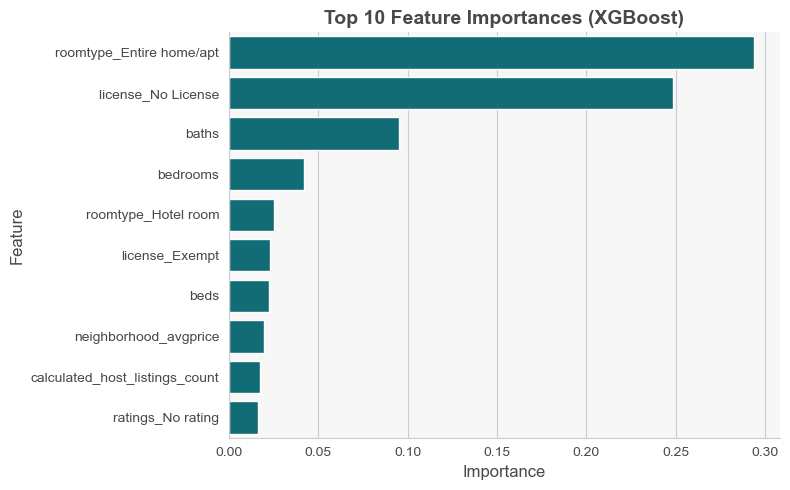

In [25]:
# Airbnb color palette
airbnb_teal = "#007A87"
background_gray = "#F7F7F7"
text_gray = "#484848"

# Select top 10 features
top_features = sorted_importances.head(10)

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

sns.barplot(x=top_features.values, y=top_features.index, color=airbnb_teal)

# Styling
plt.title("Top 10 Feature Importances (XGBoost)", fontsize=14, fontweight='bold', color=text_gray)
plt.xlabel("Importance", fontsize=12, color=text_gray)
plt.ylabel("Feature", fontsize=12, color=text_gray)
plt.xticks(color=text_gray)
plt.yticks(color=text_gray)
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')
sns.despine()

# Save if needed
plt.savefig("../plots/feature_imp.png", dpi=300)
plt.tight_layout()
plt.show()

#### Plots of predicted vs actual

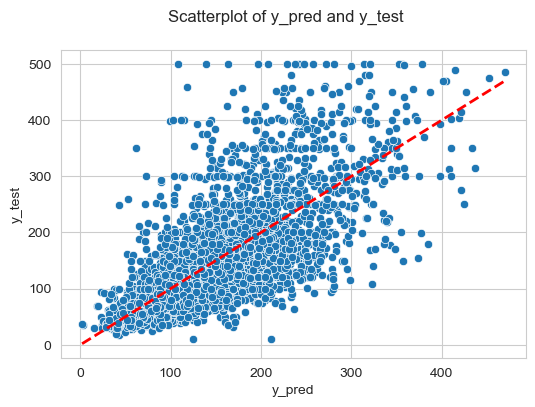

In [26]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


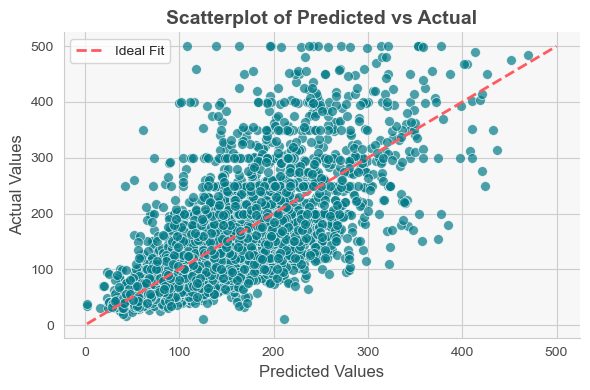

In [27]:
# Airbnb styling colors
airbnb_teal = "#007A87"
background_gray = "#F7F7F7"
text_gray = "#484848"
airbnb_red = "#FF5A5F"

# Generate line values for diagonal reference
x_vals = np.linspace(min(y_pred.min(), y_test.min()), max(y_pred.max(), y_test.max()), 100)

# Plot setup
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")

ax = sns.scatterplot(x=y_pred, y=y_test, color=airbnb_teal, edgecolor='white', alpha=0.7, s=50)
plt.plot(x_vals, x_vals, color=airbnb_red, linestyle='--', linewidth=2, label="Ideal Fit")

# Labels & title
plt.title("Scatterplot of Predicted vs Actual", fontsize=14, fontweight='bold', color=text_gray)
plt.xlabel("Predicted Values", fontsize=12, color=text_gray)
plt.ylabel("Actual Values", fontsize=12, color=text_gray)
plt.xticks(color=text_gray)
plt.yticks(color=text_gray)
plt.legend()

# Airbnb-styled background
plt.gca().set_facecolor(background_gray)
plt.gcf().set_facecolor('white')
sns.despine()

# Save if needed
# plt.savefig("airbnb_scatterplot.png", dpi=300)

plt.tight_layout()
plt.show()

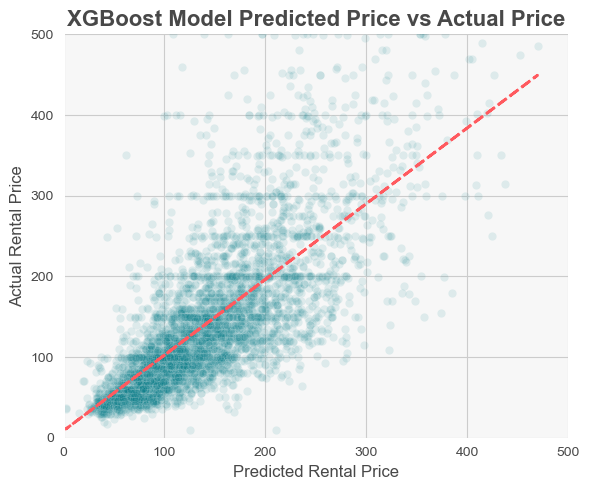

In [28]:
# Airbnb-inspired color palette
airbnb_red = '#FF5A5F'
background_gray = '#F7F7F7'
text_gray = '#484848'

# Example best-fit line (replace with actual regression if available)
line = np.polyfit(y_pred, y_test, 1)
line_fn = np.poly1d(line)

# Set style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.facecolor': background_gray,
    'axes.edgecolor': 'white',
    'axes.titleweight': 'bold',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'font.family': 'Arial',  # or 'Nunito', 'Arial', etc.
    'xtick.color': text_gray,
    'ytick.color': text_gray,
    'axes.labelcolor': text_gray,
    'figure.facecolor': 'white'
})

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, y_test, color='#007A87', alpha=0.1, edgecolors='white', linewidth=0.5)
plt.plot(y_pred, line_fn(y_pred), color=airbnb_red, linewidth=2, linestyle='--')

plt.title('XGBoost Model Predicted Price vs Actual Price', color=text_gray)
plt.xlabel('Predicted Rental Price')
plt.ylabel('Actual Rental Price')

# Zoom in: set axis limits
plt.xlim(0, 500)
plt.ylim(0, 500)

# Clean up ticks
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()
plt.tight_layout()

# Save plot
plt.savefig("../plots/xgboost_scatterplot_predvstest.png", dpi=300)

plt.show()

#### Pickle and save model

In [30]:
pickle.dump(xgb_model, open("../models/xgb_model.pkl","wb"))

_________________________________

<a id="5"></a>
### Random Forest Modeling

In [31]:
# initialize rforest
rforest_model = RandomForestRegressor()

# fit logistic regression model to xtrain
rforest_model.fit(X_train, y_train)

RandomForestRegressor()

In [33]:
# find scores
score_r2_rmse_mae(rforest_model)

Train score: 0.9354277486656111
Test score: 0.5168078211704088
RMSE: 63.43913067558295
MAE: 43.59202446330505


In [34]:
# compare y_pred to y_true

# predict y_pred values
y_pred = rforest_model.predict(X_test)

# add to df
y_truevspred = pd.DataFrame({"True_y": y_test, "Pred_y": y_pred, "Diff": (y_test - y_pred)})

# display
y_truevspred

,True_y,Pred_y,Diff
16115,357.0,229.55,127.45
1289,85.0,159.73,-74.73
2465,190.0,189.13,0.87
9515,286.0,341.10,-55.10
12319,180.0,166.59,13.41
...,...,...,...
13030,150.0,168.32,-18.32
15081,229.0,196.95,32.05
9385,100.0,163.69,-63.69
3356,214.0,172.20,41.80


#### Feature Importance

In [35]:
importances = rforest_model.feature_importances_

feature_importances = pd.Series(importances, index=X_test.columns)

feature_importances.sort_values(ascending=False)

roomtype_Entire home/apt          0.177329
longitude                         0.092379
baths                             0.082994
latitude                          0.081594
neighborhood_avgprice             0.073312
reviews_per_month                 0.064841
bedrooms                          0.060961
availability_365                  0.056307
calculated_host_listings_count    0.054084
number_of_reviews                 0.042051
beds                              0.034185
number_of_reviews_ltm             0.028514
license_No License                0.027088
minimum_nights                    0.016683
month                             0.016325
last_review_month                 0.016312
roomtype_Private room             0.015980
last_review_year                  0.010439
ratings_5                         0.008426
ratings_4.8                       0.006485
ratings_4.6                       0.005325
license_Exempt                    0.004410
ratings_4.4                       0.003666
ratings_4.2

In [37]:
# Compute permutation importance
result = permutation_importance(rforest_model, X_test, y_test, n_repeats=10, random_state=0)

# Convert to Series for plotting
perm_importances = pd.Series(result.importances_mean, index=X.columns)
perm_importances.sort_values(ascending=False)

roomtype_Entire home/apt          2.488149e-01
bedrooms                          1.064522e-01
longitude                         1.019333e-01
calculated_host_listings_count    8.939497e-02
neighborhood_avgprice             8.557155e-02
baths                             8.148966e-02
license_No License                6.442466e-02
beds                              4.970394e-02
latitude                          4.724585e-02
reviews_per_month                 3.513516e-02
availability_365                  3.232608e-02
minimum_nights                    1.562340e-02
number_of_reviews                 1.054005e-02
number_of_reviews_ltm             9.644918e-03
ratings_5                         5.677032e-03
license_Exempt                    4.375340e-03
ratings_4.8                       3.191412e-03
neighgroup_Manhattan              2.779054e-03
last_review_year                  1.539132e-03
license_Has License               6.764251e-04
roomtype_Hotel room               6.286089e-04
roomtype_Shar

#### Plots of predicted vs actual

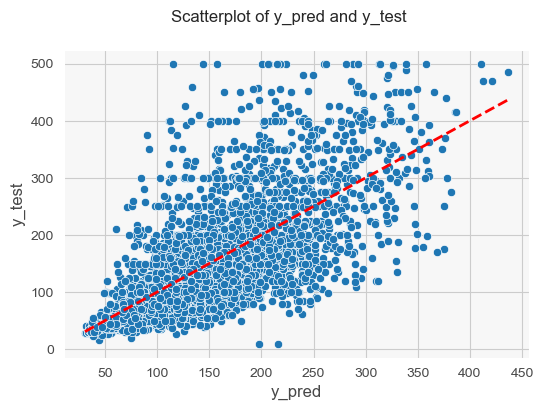

In [38]:
# scatterplot

plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=y_pred, y=y_test)
plt.suptitle("Scatterplot of y_pred and y_test")
plt.xlabel("y_pred")
plt.ylabel("y_test")

x_vals = np.linspace(y_pred.min(), y_pred.max(), 100)
ax.plot(x_vals, x_vals, color='red', linestyle='--', linewidth=2) 

plt.show()


#### Pickle and save model

In [40]:
pickle.dump(rforest_model, open("../models/rf_model.pkl","wb"))